In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.datasets import DatasetFolder

In [3]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

In [4]:
transform = transforms.Compose([
     transforms.ToTensor()])

batch_size = 32

mean = torch.Tensor([0.3185, 0.2930, 0.3016])
std = torch.Tensor([0.2735, 0.2628, 0.2660])

In [5]:
trainset = ImageFolder("trafic_32/", transform=transform)

train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

train_dataset, test_dataset = random_split(trainset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=False, num_workers=16)

classes = trainset.classes

/home/natalia/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [73]:
def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(10,10+num)], dim=0)

/home/natalia/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


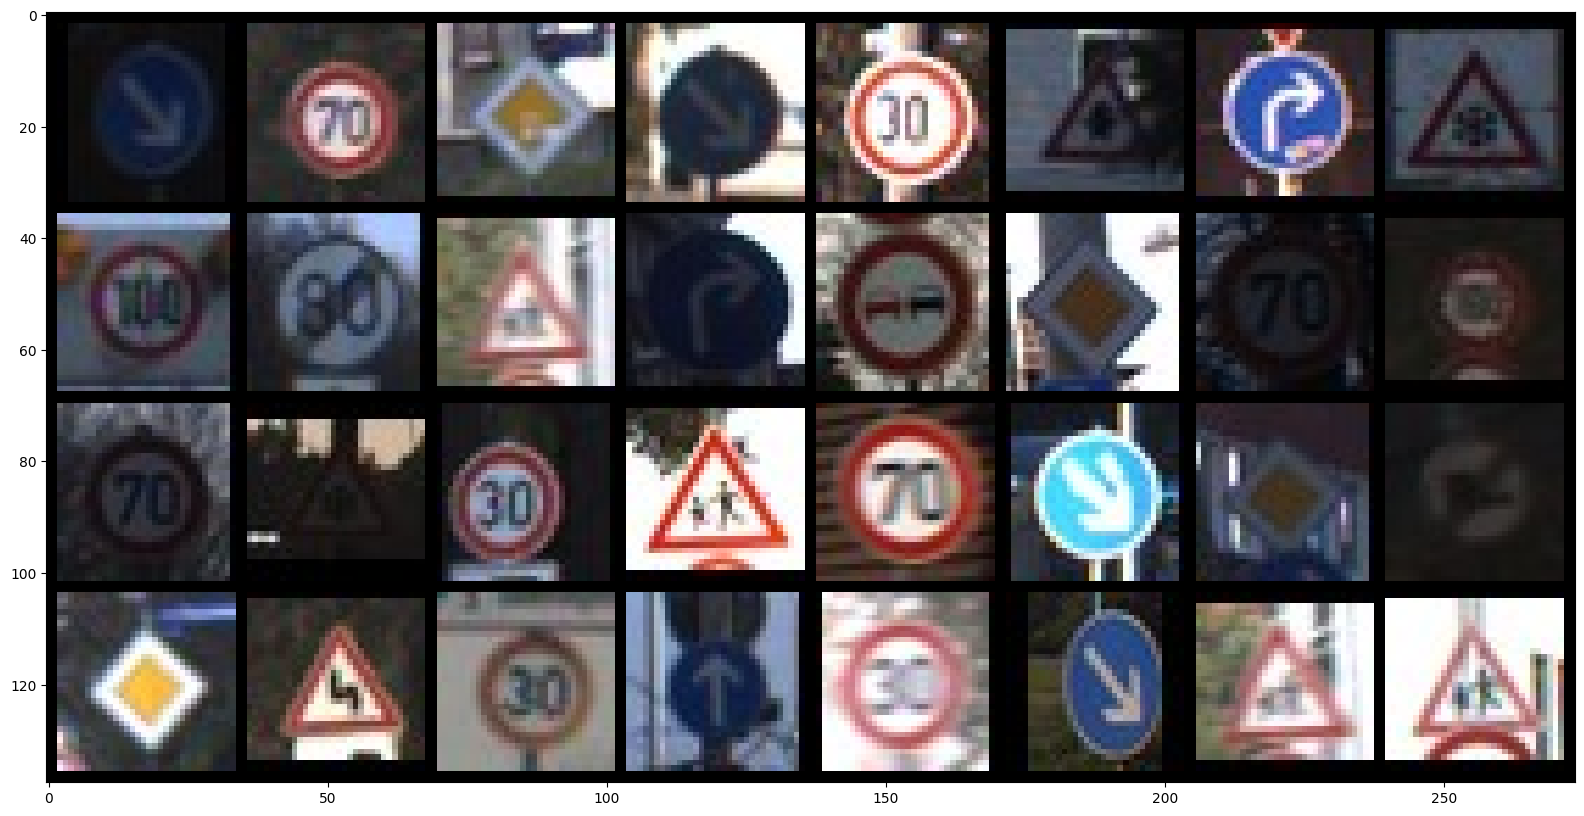

00038 00004 00012 00038 00001 00011 00033 00030 00007 00006 00028 00033 00009 00012 00004 00007 00004 00030 00001 00028 00004 00038 00012 00042 00012 00021 00001 00035 00001 00038 00028 00028


In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [9]:
images, labels = next(iter(train_loader))
images[0:1].size()

torch.Size([1, 3, 32, 32])

In [95]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    torch.save(generated_imgs.cpu().detach(),"poniedzialek_iwanska_szczygielski.pt")
    return generated_imgs

In [67]:

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.fc_mean  = nn.Linear(128*8*8, latent_dim)
        self.fc_var   = nn.Linear(128*8*8, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.norm1(self.conv1(x)))
        x = self.LeakyReLU(self.norm2(self.conv2(x)))
        x = self.LeakyReLU(self.norm3(self.conv3(x)))
        x = self.LeakyReLU(self.norm4(self.conv4(x)))
        x = torch.flatten(x, 1)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, 128*8*8)
        self.norm1 = nn.BatchNorm1d(128*8*8)
        self.conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.norm3 = nn.BatchNorm2d(32)
        self.conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.norm4 = nn.BatchNorm2d(16)
        self.conv4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.norm1(self.fc_1(x)))
        h = h.view(-1, 128, 8, 8)  
        h = self.LeakyReLU(self.norm2(self.conv1(h)))
        h = self.LeakyReLU(self.norm3(self.conv2(h)))
        h = self.LeakyReLU(self.norm4(self.conv3(h)))
        x_hat = torch.sigmoid(self.conv4(h))
        x_hat = x_hat[:, :, :32, :32]
        return x_hat

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)
        
    def reparameterization(self, mean, var):
        z = torch.randn_like(mean) * var + mean
        return z
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var


vae = VAE(latent_dim=32).to(device)

def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD
        
criterion = vae_loss_function
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [68]:
num_epochs = 50
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               
        optimizer.step()              
        optimizer.zero_grad()  
    L1_list = []
    
    # if n % 10 == 0:
    for x, _ in iter(test_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 48697.570843089, test L1 = 0.08591726952330853
Epoch 1 loss 47004.57938129141, test L1 = 0.07678419091110307
Epoch 2 loss 46579.183468319956, test L1 = 0.07223562466177513
Epoch 3 loss 46362.27195523541, test L1 = 0.07135946982032884
Epoch 4 loss 46214.39625740635, test L1 = 0.0681586532543103
Epoch 5 loss 46113.1165633362, test L1 = 0.06799263722164844
Epoch 6 loss 46030.29830749076, test L1 = 0.06589816766601753
Epoch 7 loss 45971.455380749874, test L1 = 0.06579065256244768
Epoch 8 loss 45911.457814690046, test L1 = 0.06546240187878531
Epoch 9 loss 45869.31572633951, test L1 = 0.06443842103689666
Epoch 10 loss 45824.157414707566, test L1 = 0.06607346380568617
Epoch 11 loss 45783.0507135576, test L1 = 0.06417346854762333
Epoch 12 loss 45750.082518038034, test L1 = 0.06329108689858662
Epoch 13 loss 45718.18317963176, test L1 = 0.06378630783439167
Epoch 14 loss 45699.60308757008, test L1 = 0.06488691311238742
Epoch 15 loss 45668.794048842065, test L1 = 0.0627678612595409
Ep

In [1]:
generated_imgs = generate_images(vae, 1000, device)
generated_imgs.size()
grid = torchvision.utils.make_grid(generated_imgs, nrow=10, normalize=False)
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(15,10))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

NameError: name 'generate_images' is not defined

In [85]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False)
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

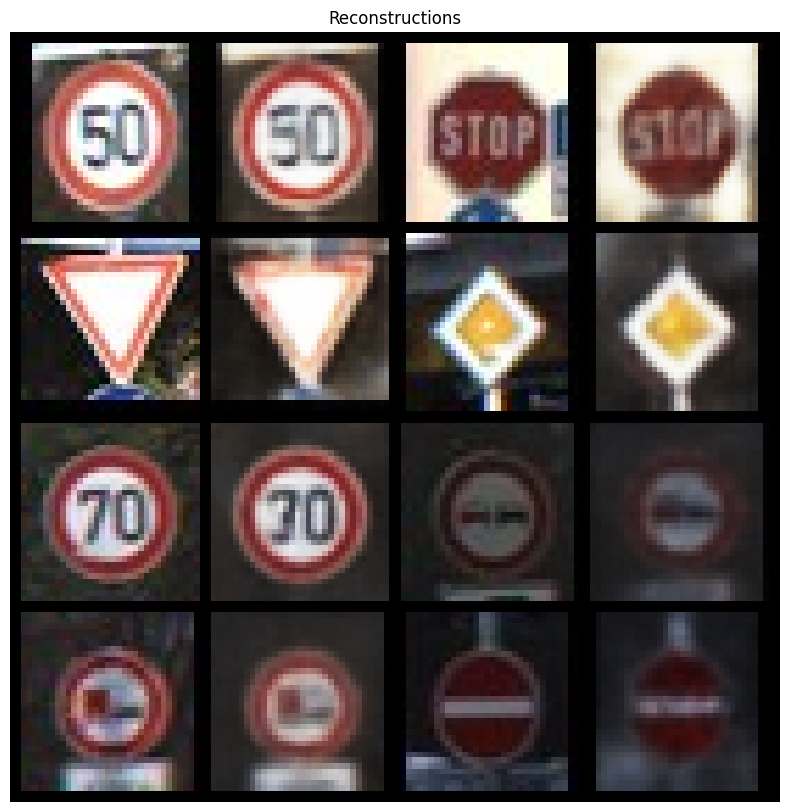

In [88]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)